In [1]:
import pyzx as zx
from qec import css_encoder, bipartite_css_zero_state, css_zero_state

steane_stabilisers = [
    [1, 1, 1, 1, 0, 0, 0],
    [0, 1, 1, 0, 1, 1, 0],
    [0, 0, 1, 1, 0, 1, 1]
]
steane_logical = [
    [1, 1, 1, 1, 1, 1, 1],
]
encoder = css_encoder(steane_stabilisers, steane_logical)
encoder.compose(encoder.adjoint())
zx.draw(encoder)

In [2]:
zero_state = bipartite_css_zero_state(steane_stabilisers)
zx.draw(zero_state, labels=True)

In [3]:
from fault_equivalent_rewrites import decompose_bipartite_css_state_FE

decompose_bipartite_css_state_FE(zero_state, None)
zx.draw(zero_state)

In [4]:
stabilisers_15_7_3 = [
    [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1],
    [0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
    [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
]

zero_state = bipartite_css_zero_state(stabilisers_15_7_3)
zx.draw(zero_state, labels=True)

In [5]:
decompose_bipartite_css_state_FE(zero_state, None)
zx.draw(zero_state)

In [6]:
import pyzx as zx
from pyzx import VertexType, EdgeType, Graph
from fault_equivalent_rewrites import *

g = Graph()
v = g.add_vertex(VertexType.Z, 0, 0)
for i in range(4):
    nv = g.add_vertex(VertexType.BOUNDARY, 2 * (i // 2) - 4, 2 * (i % 2) - 1)
    g.add_edge((v, nv))

zx.draw(g)

In [7]:
if check_unfuse_4_FE(g, v):
    unfuse_4_FE(g, v)

zx.draw(g)

In [8]:
import pyzx as zx
from pyzx import VertexType, EdgeType, Graph
from fault_equivalent_rewrites import *

g = Graph()
v = g.add_vertex(VertexType.Z, 0, 0)
for i in range(20):
    nv = g.add_vertex(VertexType.BOUNDARY, 2 * (i // 3) - 1, 2 * (i % 3) - 1)
    g.add_edge((v, nv))

zx.draw(g)

In [9]:
if check_unfuse_n_2FE(g, v):
    unfuse_n_2FE(g, v)

zx.draw(g)

In [10]:
import pyzx as zx
from pyzx import VertexType, EdgeType, Graph
from fault_equivalent_rewrites import *

def generate_zx_graph(N: int, W: int) -> BaseGraph:
    """
    Generates a ZX-diagram graph for the given N and W parameters.
    N can be any integer.
    """
    g = zx.Graph()
    # The position is calculated to keep the graph centered.
    v = g.add_vertex(VertexType.Z, (N - 1) / 2, 0)

    # Add N boundary vertices and connect them to the central spider
    for i in range(N):
        nv = g.add_vertex(VertexType.BOUNDARY, i, 1)
        g.add_edge((v, nv))

    if recursive_unfuse_FE(g, v, w=W):
        return g
    else:
        return None

zx.draw(generate_zx_graph(7, None))

✅ Number of flags: 3
[1, 10, 11, 16, 17, 18, 19, 13, 12, 8, 14, 15, 6]


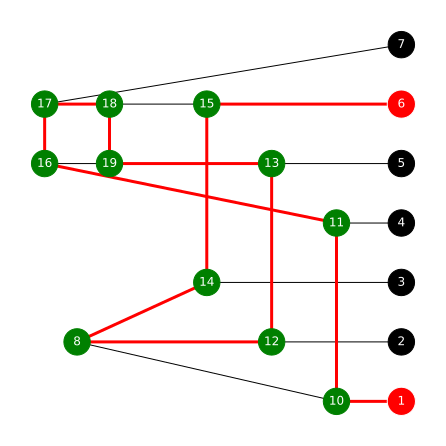

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

color_map = {VertexType.BOUNDARY: 'black', VertexType.Z: 'green'}


def zx_diagram_to_networkx_graph(graph):
    graph_dict = graph.to_dict()
    G = nx.Graph()
    pos = {}
    node_types = {}
    for v_data in graph_dict['vertices']:
        G.add_node(v_data['id'])
        pos[v_data['id']] = v_data['pos']
        node_types[v_data['id']] = v_data['t']
    for u, v, _ in graph_dict['edges']:
        G.add_edge(u, v)
    return G, pos, node_types


# --- Step 2: Function to find ALL Hamiltonian paths on the Z-subgraph ---
def find_all_hamiltonian_paths(graph):
    """
    Yields all Hamiltonian paths in a graph using backtracking.
    """
    n = len(graph.nodes)
    for start_node in graph.nodes:
        path = [start_node]
        visited = {start_node}

        def search(current_path):
            if len(current_path) == n:
                yield current_path
                return

            last_node = current_path[-1]
            for neighbor in graph.neighbors(last_node):
                if neighbor not in visited:
                    visited.add(neighbor)
                    yield from search(current_path + [neighbor])
                    visited.remove(neighbor) # Backtrack

        yield from search(path)

# --- Step 3: Find a path that can be anchored by boundary nodes ---

def find_boundary_anchored_hamiltonian_path(z_subgraph, boundary_nodes):
    full_path = None
    for z_path in find_all_hamiltonian_paths(z_subgraph):
        z_start, z_end = z_path[0], z_path[-1]

        # Find boundary neighbors for the start and end of the Z-path
        start_boundary_neighbors = boundary_nodes.intersection(G.neighbors(z_start))
        end_boundary_neighbors = boundary_nodes.intersection(G.neighbors(z_end))

        # Check if a valid start/end pair of boundary nodes exists
        found_solution = False
        for b_start in start_boundary_neighbors:
            for b_end in end_boundary_neighbors:
                if b_start != b_end:
                    full_path = [b_start] + z_path + [b_end]
                    found_solution = True
                    break
            if found_solution:
                break
        if found_solution:
            break # Exit the main loop once the first solution is found
    return full_path


def count_z_nodes(graph_data: dict[str, list[dict]], z_type) -> int:
    """Counts the number of vertices of a specific type in a graph dictionary."""
    # This uses a generator expression within sum() for a concise and efficient count.
    return sum(1 for vertex in graph_data['vertices'] if vertex['t'] == z_type)

N = 7
W = 4
graph = generate_zx_graph(N, W)
G, pos, node_types = zx_diagram_to_networkx_graph(graph)
z_nodes = [n for n, t in node_types.items() if t == VertexType.Z]
boundary_nodes = {n for n, t in node_types.items() if t == VertexType.BOUNDARY}
z_subgraph = G.subgraph(z_nodes)
full_path = find_boundary_anchored_hamiltonian_path(z_subgraph, boundary_nodes)

plt.figure(figsize=(6, 6))
node_colors = ['green' if node_types[n] == VertexType.Z else 'black' for n in G.nodes()]
path_edges = list(zip(full_path, full_path[1:])) if full_path else []

# Draw the base graph
nx.draw(G, pos, with_labels=True, node_color=node_colors, font_color='white', node_size=700)

# Highlight the final path
if full_path:
    nx.draw_networkx_edges(
        G, pos, edgelist=path_edges,
        edge_color='red', width=3.0
    )
    # Highlight the start and end boundary nodes
    nx.draw_networkx_nodes(
        G, pos, nodelist=[full_path[0], full_path[-1]],
        node_color='red', node_size=800, edgecolors='white'
    )


z_node_count = count_z_nodes(graph.to_dict(), VertexType.Z)

print(f"✅ Number of flags: {(z_node_count - N + 2) // 2}")
print(full_path)

plt.savefig('hamiltonian_path.png', format='png')

In [45]:
import pandas as pd

results = {}
for W in [math.inf]:
    row_data = {}
    for N in range(1, 51):
        graph = generate_zx_graph(N, None if W is None else W + 1)
        if graph is None:
            row_data[N] = None
            continue
        if N <= 1:
            row_data[N] = 0
            continue
        G, pos, node_types = zx_diagram_to_networkx_graph(graph)
        z_nodes = [n for n, t in node_types.items() if t == VertexType.Z]
        boundary_nodes = {n for n, t in node_types.items() if t == VertexType.BOUNDARY}
        z_subgraph = G.subgraph(z_nodes)
        # full_path = find_boundary_anchored_hamiltonian_path(z_subgraph, boundary_nodes)
        #
        # node_colors = ['green' if node_types[n] == VertexType.Z else 'black' for n in G.nodes()]
        # path_edges = list(zip(full_path, full_path[1:])) if full_path else []

        z_node_count = count_z_nodes(graph.to_dict(), VertexType.Z)
        row_data[N] = z_node_count

        print(f"{N = } {W = } Number of flags: {row_data[N]}")

    results[W] = row_data

df = pd.DataFrame.from_dict(results, orient='index')

# Label the axes for clarity.
df.index.name = 't'
df.columns.name = 'N'
print(df)

N = 2 W = inf Number of flags: 1
N = 3 W = inf Number of flags: 1
N = 4 W = inf Number of flags: 4
N = 5 W = inf Number of flags: 5
N = 6 W = inf Number of flags: 8
N = 7 W = inf Number of flags: 11
N = 8 W = inf Number of flags: 16
N = 9 W = inf Number of flags: 17
N = 10 W = inf Number of flags: 20
N = 11 W = inf Number of flags: 23
N = 12 W = inf Number of flags: 28
N = 13 W = inf Number of flags: 31
N = 14 W = inf Number of flags: 36
N = 15 W = inf Number of flags: 41
N = 16 W = inf Number of flags: 48
N = 17 W = inf Number of flags: 49
N = 18 W = inf Number of flags: 52
N = 19 W = inf Number of flags: 55
N = 20 W = inf Number of flags: 60
N = 21 W = inf Number of flags: 63
N = 22 W = inf Number of flags: 68
N = 23 W = inf Number of flags: 73
N = 24 W = inf Number of flags: 80
N = 25 W = inf Number of flags: 83
N = 26 W = inf Number of flags: 88
N = 27 W = inf Number of flags: 93
N = 28 W = inf Number of flags: 100
N = 29 W = inf Number of flags: 105
N = 30 W = inf Number of flags:

In [46]:
from collections import defaultdict

# 2. Group identical columns
col_groups = defaultdict(list)
for col in df.columns:
    # Use a tuple of the column's values as the dictionary key
    col_key = tuple(df[col])
    col_groups[col_key].append(col)

# col_groups now looks like:
# {(0, 0, 0, 0, 0, 0): ['1', '2', '3'],
#  (1, 1, 1, 1, 1, 1): ['4', '5'],
#  (1, 2, 2, 2, 2, 2): ['6'], ...}

# 3. Build the new DataFrame
# We sort the groups by the integer value of their first column name
# to keep the original column order (e.g., '2' before '10')
sorted_groups = sorted(col_groups.values(), key=lambda group: int(group[0]))

combined_df = pd.DataFrame(index=df.index)


for group in sorted_groups:
    # Create the new name, e.g., "1-3" or "4-5"
    new_name = f"{group[0]}-{group[-1]}" if len(group) > 1 else str(group[0])

    # Get the data from the first column in the group (all are identical)
    combined_df[new_name] = df[group[0]]

pd.set_option('display.width', 500)
# 4. Display the result
print(combined_df)

     1  2-3  4  5  6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27   28   29   30   31   32   33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48   49   50
t                                                                                                                                                                                                                          
inf  0    1  4  5  8  11  16  17  20  23  28  31  36  41  48  49  52  55  60  63  68  73  80  83  88  93  100  105  112  119  128  129  132  135  140  143  148  153  160  163  168  173  180  185  192  199  208  211  216
